In [2]:
%load_ext autoreload
%autoreload 2
import parmap
import pandas as pd
from tqdm import tqdm,tqdm_notebook
from models.tokenization import *
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from models.model_architecture import *
from models.train_eval import *
from models.model_utils import *
from models.tokenization import *
parent_path='Data/'

W0130 21:56:44.426367 140034566559552 word.py:92] Falling back to default tokenizer, the NLTK's `TreebankWordTokenizer()`.
I0130 21:56:44.583137 140034566559552 dictionary.py:209] adding document #0 to Dictionary(0 unique tokens: [])
I0130 21:56:44.584788 140034566559552 dictionary.py:216] built Dictionary(12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...) from 9 documents (total 29 corpus positions)


In [14]:
params={'model_path':'xlm-roberta-base',
        'preprocess_doc':False,
        'max_length':256,
        'batch_size':16,
        'hidden_size':128,
        'weights':[1.0,1.0],
        'load_saved':True,
        'seq_model':'lstm',
        'data_path':parent_path+'fear_speech_data.json',
        'max_sentences_per_doc':5,
        'transformer_type':'normal_transformer',
        'take_tokens_from':'last',
        'device':'cpu',
        'learning_rate':2e-5,
        'epsilon':1e-8,
        'random_seed':2020,
        'epochs':20,
        'max_memory':0.6,
        'freeze_bert':False
       }

In [12]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    temp=e_x / e_x.sum(axis=0) # only difference
    
    if np.isnan(temp).any()==True:
        return [0.0,1.0,0.0]
    else:
        return temp

def return_dataframe(path):
    with open(path, 'r') as fp:
        json_data=json.load(fp)
    text_tuples=[]
    for key in json_data.keys():
        element = json_data[key]
        count_fearspeech=element['annotation_list'].count('Fear speech')
        count_normal=element['annotation_list'].count('Normal')

        if(count_fearspeech>count_normal):
            one_fear_speech=1
        else:
            one_fear_speech=0
        text_tuples.append([element['message_text'],one_fear_speech])
    annotated_df = pd.DataFrame(text_tuples,columns=['message_text','one_fear_speech'])
    return annotated_df    
    

class modelPred():
    def __init__(self,params,fold):
        self.params=params
        if torch.cuda.is_available() and self.params['device']=='cuda':    
            # Tell PyTorch to use the GPU.    
            self.device = torch.device("cuda")
            deviceID = get_gpu(self.params)
            torch.cuda.set_device(deviceID[0])
        else:
            print('Since you dont want to use GPU, using the CPU instead.')
            self.device = torch.device("cpu")
        
        
        self.model=select_transformer_model(params['transformer_type'],params['model_path'],params,count_skf)
       
        if(self.params["device"]=='cuda'):
            self.model.cuda()
        self.model.eval()
    
    def return_probab(self,sentences_list):
        """Input: should be a list of sentences"""
        """Ouput: probablity values"""
        params=self.params
        device = self.device

        X_test,X_test_mask= encode_sent(sentences_list,params,tokenizer)
        y_test=np.zeros((len(X_test),))
        test_dataloader=return_dataloader_sent(X_test,X_test_mask,y_test,params,is_train=False)
        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        # Tracking variables
        

        print("Running eval on test data...")
        t0 = time.time()
        true_labels=[]
        pred_labels=[]
        logits_all=[]
        input_mask_all=[]

        # Evaluate data for one epoch
        for step, batch in tqdm(enumerate(test_dataloader),total=len(test_dataloader)):

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)


            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention vals
            #   [2]: attention mask
            #   [3]: labels 
            b_input_ids = batch[0].to(device)
            b_att_val = batch[1].to(device)
            b_input_mask = batch[2].to(device)
            b_labels = batch[3].to(device)


            # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            #model.zero_grad()        
            outputs = self.model(b_input_ids,
                attention_mask=b_input_mask, 
                labels=None)
            logits = outputs

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.detach().cpu().numpy()

            pred_labels+=list(np.argmax(logits, axis=1).flatten())
            true_labels+=list(label_ids.flatten())
            logits_all+=list(logits)
            input_mask_all+=list(batch[2].detach().cpu().numpy())


        logits_all_final=[]
        for logits in logits_all:
            logits_all_final.append(list(softmax(logits)))


        return np.array(logits_all_final)

In [ ]:
import random 
from lime.lime_text import LimeTextExplainer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
annotated_df=return_dataframe(params['data_path'])

#### Preprocessing
params_preprocess={'remove_numbers': True, 'remove_emoji': True, 'remove_stop_words': False, 'tokenize': False}
list_sents=[preprocess_sent(ele,params=params_preprocess) for ele in tqdm_notebook(annotated_df['message_text'],total=len(annotated_df))]


#### Data_arrays
X_0 = np.array(list_sents,dtype='object')
y_0 = np.array(annotated_df['one_fear_speech'])



if(params['weights']== [1.0,1.0]):
    params['weights']=list(class_weight.compute_class_weight("balanced", np.unique(y_0),y_0).astype(float))

print('Loading tokenizer...')


tokenizer = AutoTokenizer.from_pretrained(params['model_path'])

if torch.cuda.is_available() and params['device']=='cuda':    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    deviceID = get_gpu(params)
    torch.cuda.set_device(deviceID[0])
else:
    print('Since you dont want to use GPU, using the CPU instead.')
    device = torch.device("cpu")


list_dict=[]
skf = StratifiedKFold(n_splits=5, random_state= 2020)
count_skf=0


explainer = LimeTextExplainer(class_names=['non fear speech','fear speech'],
                              split_expression='\s+',random_state=333,bow=False)

y_ground_all=[]
y_pred_all=[]

for train_index, test_index in skf.split(X_0, y_0):
    print('======== Fold {:} / {:} ========'.format(count_skf,5))
    print(train_index[0:5], test_index[0:5])
    count_skf+=1
    print("")
    X_train, X_test = X_0[train_index], X_0[test_index]
    y_train, y_test = y_0[train_index], y_0[test_index]
    
    
    model_cl=modelPred(params,count_skf)
    
    
    logits_all_final=model_cl.return_probab(X_test)
    
    index_ground_nfs=[]
    index_ground_fs=[]
    
    
    for i in tqdm(range(len(y_test))):
        pred_id=np.argmax(logits_all_final[i])
        ground_label=y_test[i]
        y_ground_all.append(ground_label)
        y_pred_all.append(pred_id)
        if(pred_id!=ground_label):
            if(ground_label==1):
                index_ground_fs.append(i)
            else:
                index_ground_nfs.append(i)
    
    for i in random.sample(index_ground_fs,20):
        temp={}
        exp = explainer.explain_instance(X_test[i], model_cl.return_probab, num_features=6, top_labels=2,num_samples=50)
        pred_id=np.argmax(exp.predict_proba)
        ground_label=y_test[i]
        temp["text"]=X_test[i]
        temp["annotation"]=ground_label
        temp["classification"]=pred_id
        temp["classification_scores"]={"non fear speech":exp.predict_proba[0],"fear speech":exp.predict_proba[1]}
        temp["text_explained"]=exp.as_list()
        list_dict.append(temp)
    
    for i in random.sample(index_ground_nfs,20):
        temp={}
        exp = explainer.explain_instance(X_test[i], model_cl.return_probab, num_features=6, top_labels=2,num_samples=50)
        pred_id=np.argmax(exp.predict_proba)
        ground_label=y_test[i]
        temp["text"]=X_test[i]
        temp["annotation"]=ground_label
        temp["classification"]=pred_id
        temp["classification_scores"]={"non fear speech":exp.predict_proba[0],"fear speech":exp.predict_proba[1]}
        temp["text_explained"]=exp.as_list()
        list_dict.append(temp)

/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Loading tokenizer...
Since you dont want to use GPU, using the CPU instead.
======== Fold 0 / 5 ========
[870 872 873 874 875] [0 1 2 3 4]

Since you dont want to use GPU, using the CPU instead.


/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
  0%|          | 0/60 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


100%|██████████| 4/4 [01:18<00:00, 19.60s/it]


Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


100%|██████████| 4/4 [01:12<00:00, 18.07s/it]


Running eval on test data...


100%|██████████| 4/4 [00:38<00:00,  9.60s/it]


Running eval on test data...


100%|██████████| 4/4 [16:16<00:00, 244.01s/it]


Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


100%|██████████| 4/4 [02:15<00:00, 33.86s/it]


======== Fold 1 / 5 ========
[0 1 2 3 4] [870 872 873 874 875]

Since you dont want to use GPU, using the CPU instead.


  0%|          | 0/60 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


100%|██████████| 4/4 [00:16<00:00,  4.01s/it]


Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


======== Fold 2 / 5 ========
[0 1 2 3 4] [1771 1772 1773 1774 1775]

Since you dont want to use GPU, using the CPU instead.


  0%|          | 0/60 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


======== Fold 3 / 5 ========
[0 1 2 3 4] [2757 2758 2759 2761 2762]

Since you dont want to use GPU, using the CPU instead.


  0%|          | 0/60 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


  0%|          | 0/4 [00:00<?, ?it/s]

Running eval on test data...


 50%|█████     | 2/4 [00:20<00:19,  9.58s/it]

In [20]:
from sklearn.metrics import confusion_matrix,make_scorer
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import classification_report, precision_recall_fscore_support

In [21]:
testf1=f1_score(y_ground_all, y_pred_all, average='macro')
testacc=accuracy_score(y_ground_all,y_pred_all)
testrocauc=roc_auc_score(y_ground_all, y_pred_all,average='macro')
testprecision=precision_score(y_ground_all, y_pred_all, average='binary')

In [22]:
print('val_fscore',testf1)
print('val_accuracy',testacc)
print('val_rocauc',testrocauc)
print('val_precision',testprecision)

val_fscore 0.6531715907724819
val_accuracy 0.7258469259723965
val_rocauc 0.6693842497257558
val_precision 0.44176430048242593


In [92]:
import json

class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
            np.int16, np.int32, np.int64, np.uint8,
            np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32, 
            np.float64)):
            return float(obj)
        elif isinstance(obj,(np.ndarray,)): #### This is the fix
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


with open('lime_explanation.txt', 'w') as fp:
        
    for ele in list_dict:
        fp.write("====================Start=======================\n")
        fp.write(json.dumps(ele,cls=NumpyEncoder,ensure_ascii=False))
        fp.write("====================End=======================\n")
        
        

In [93]:
len(list_dict)

0

In [94]:
from sklearn.metrics import confusion_matrix#Fit the model
cf_matrix = confusion_matrix(y_ground_all,y_pred_all)
print(cf_matrix)

[[2979  661]
 [ 505  637]]


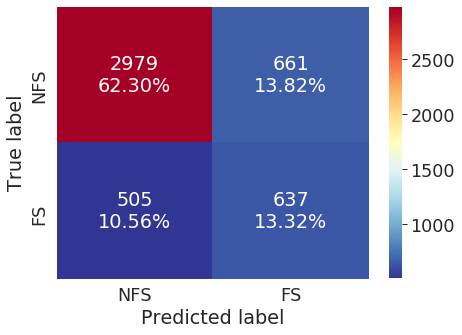

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (7, 5)
sns.set(context='paper',style='white',font_scale=2.0)

#labels = [‘True Neg’,’False Pos’,’False Neg’,’True Pos’]
categories = ['NFS', 'FS']
make_confusion_matrix(cf_matrix,
                      categories=categories, 
                      cmap='RdYlBu_r',
                      sum_stats=False)
plt.savefig('../Fear_speech_results/confusion_matrix.pdf',bbox_inches='tight',dpi=400)